In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# the following dataset emulates the joint information from a companies HR file and medical exam
# our goal is to try to approximate salaries from this information
# we have chosen to use a KNN regression
salary = pd.read_csv('salaries.csv')
salary.head()

In [ ]:
salary.shape

# Formal transformations

### One Hot encoding

##### So far we've 3 features that are with a categorical form

- Experience
- Gender
- Daltonic

In [ ]:
salary['Gender'].value_counts()

In [ ]:
salary['Daltonic'].value_counts(dropna=False)

In [35]:
#since we only accept numeric values, we have to turn the categorical variables into numerics
# you can also use sklearn.preprocessing.OneHotEncoder

dalt_df = pd.get_dummies(salary['Daltonic'], prefix='Dalt', drop_first=False, dtype=int)

In [ ]:
salary.shape[0]

In [ ]:
dalt_df.shape[0]

In [ ]:
salary.shape[0] == dalt_df.shape[0]

In [39]:
# Join data
salary_transformed = pd.merge(
    salary,
    dalt_df,
    left_index = True,
    right_index= True
)

In [ ]:
salary_transformed.head()

In [42]:
salary_transformed.drop(columns = ['Daltonic'], inplace=True)

In [ ]:
salary_transformed.head()

### Label Encoding

In [45]:
# label encoding - for when the categories need to be numbers but the values of those numbers do not matter
# you can also use sklearn.preprocessing.LabelEncoder

# First clean Experience column
salary_transformed['Experience'] = salary_transformed['Experience'].replace({'Junior': 0, 'Senior': 1})

In [47]:
# Now with gender:
salary_transformed['Gender'] = salary_transformed['Gender'].replace( {'Female': 1, 'Male': 0}) 


In [ ]:
salary_transformed.head()

### Binning

In [ ]:
# your code here

pd.cut(salary_transformed['Height'], 5, labels= ['very short', 'short', 'average', 'tall', 'very tall'])

In [ ]:
salary_transformed['Height'].hist()

In [ ]:
# your code here

### Feature Selection

In [ ]:
# we can now drop the non-numerics and keep only numeric columns
salary_transformed.head()

## ML Workflow

#### Train Test Split

In [ ]:
# now we will create the usual train-test splits
# 1st Step - Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(salary_transformed.drop(columns= ['Salary']) , salary_transformed['Salary'])

In [ ]:
X_train.head()

In [ ]:
y_train

In [ ]:
X_test.head()

In [ ]:
y_test

#### Model creation

In [64]:
# let's jump right to a model
# notice the KNN regressor version
from sklearn.neighbors import KNeighborsRegressor

# create knn, don't forget Hyperparameter
knn = KNeighborsRegressor(n_neighbors=3)

In [ ]:
salary_transformed.head()

#### Model Fit

In [ ]:
# training the model on raw data
knn.fit(X_train, y_train)

#### Model predict

In [ ]:
X_test.head()

In [ ]:
y_test

In [ ]:
# testing algorithm on raw test
y_pred = knn.predict(X_test)
y_pred[:5]

In [ ]:
y_test[:5]

##### Model score vs using metric

In [ ]:
# this we are doing with the model.score
print("This is the result using model.score: ", knn.score(X_test, y_test))


In [ ]:
# this action is doing this:
y_pred = knn.predict(X_test)
# if it's a regression model
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)
print("This is what's actually happening in the background:", r2_score(y_test, y_pred))



##### For classification problems model.score calculates accuracy
##### For regression problems model.score calculates r2_score (coefficient of determination)


#### Model metric - MSE

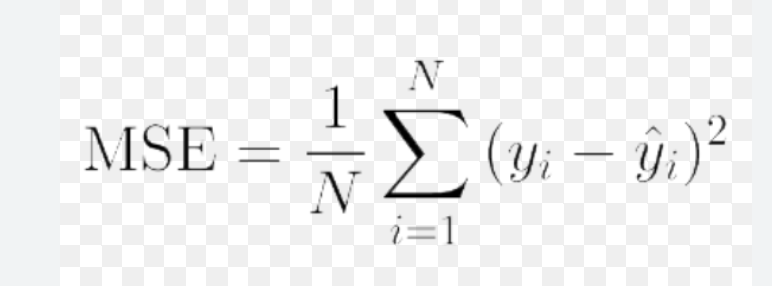

In [ ]:
from sklearn.metrics import mean_squared_error


mse_salary = mean_squared_error(y_test, y_pred)
mse_salary



In [ ]:
np.sqrt(mse_salary)

In [ ]:
salary_transformed.head()

In [ ]:
X_train.head()

In [ ]:
# Descriptive Stats:
# mean
# median
# mode
# range
# std - standard deviation
# coefficient of variation
# min 
# max
# Quartiles
# percentiles


In [ ]:
salary_transformed.describe()

## Improving model using Feature Scaling and Selection

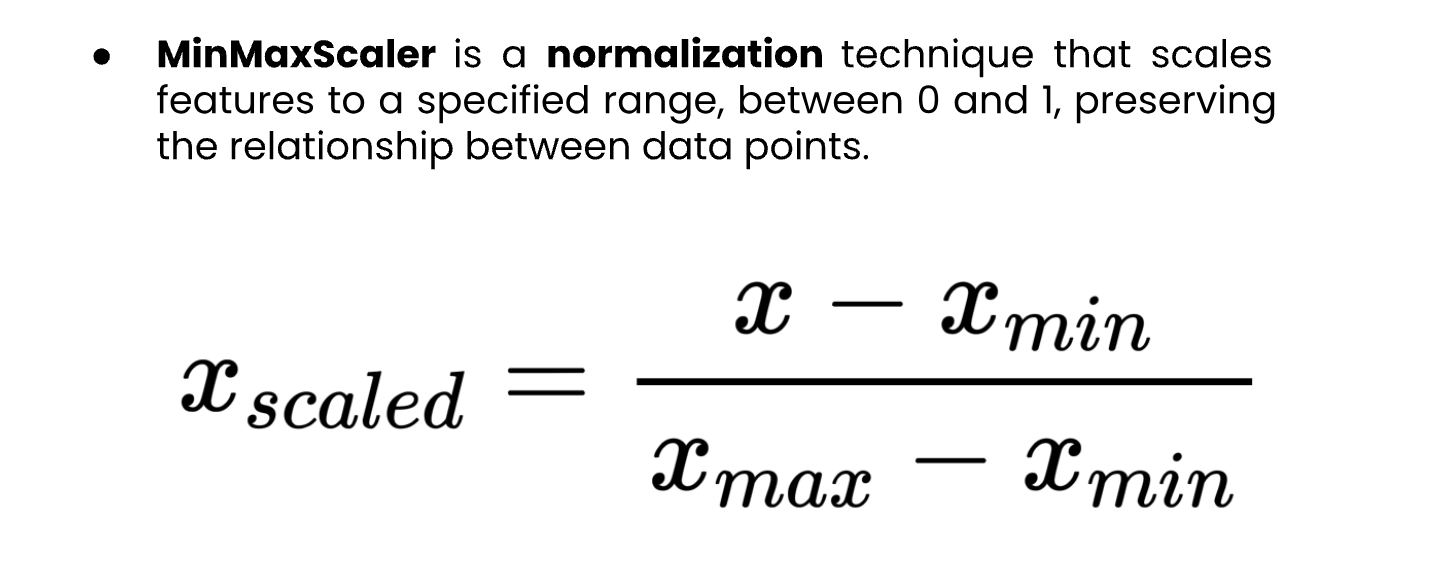

In [ ]:
# Height:
# min : 147.163544	
# max : 187.750789

salary_transformed.head(1)

In [ ]:
entry_1_minmax_scaled = (160 - 147) / (187 - 147)
entry_1_minmax_scaled

### Normalization

In [ ]:
#let's apply a normalization of the features since "flexibility" seems to count 200 times more than Daltonic_None
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# For scaling data we first instantiate the scaler
normalizer = MinMaxScaler()

# then we fit the scaler with our training data!!!
normalizer = normalizer.fit(X_train)

# notice how we only use the **X_train** data to fit?
# we want to use only the training data to normalize (establishing maximum and minimum values) to avoid data "leakage" from the test dataset
# if we used data from the test dataset, the test results would be biased by having some info from the test set

normalizer

In [ ]:
# now that we have our normalizer we use it for both training and testing (and in the future for unseen data as well!)

X_train_normalized = normalizer.transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, columns = X_train.columns)
X_train_normalized.head()

In [ ]:
# transform X_test
X_test_normalized = normalizer.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, columns = X_test.columns)
X_test_normalized.head()

#### Model recreation and testing

In [ ]:
# let's see if this normalization improves our model
# creating model
knn_with_scaling =  KNeighborsRegressor(n_neighbors=3)
# training the model on normalized data
knn_with_scaling.fit(X_train_normalized, y_train)

# testing algorithm on normalized test
y_pred_norm = knn_with_scaling.predict(X_test_normalized)

# metrics scoring
knn_with_scaling.score(X_test_normalized, y_test)


In [ ]:
# MSE

mse_salary_normalized = mean_squared_error(y_test, y_pred_norm)


np.sqrt(mse_salary_normalized)


### Feature Selection - Correlation Tresholds

In [ ]:
# let's see if our variables are too dependent
pyplot as plt

In [ ]:
# A very common way to visualize the results discussed above is to create a correlation matrix.
import matplotlib.pyplot as plt
import seaborn as sn



#Set up mask for triangle representation


# Set up the matplotlib figure

# Generate a custom diverging colormap

# Draw the heatmap with the mask and correct aspect ratio


In [ ]:
# very clear that all variables are essentially the same! Except for experience!
# what is the effect of this?

#let's get rid of such variables


In [ ]:
# creating our knn model

# training the model on reduced, normalized data

# testing algorithm on reduced, normalized test


# metrics scoring


# Feature manipulation for signal boosting

In [ ]:
# we want to understand what drives loss of energy in our windfarms
energy = pd.read_csv('energy_loss.csv')
energy.head()

In [ ]:
# let's try to predict it "raw"
X = energy[['Voltage','Rotation','Stability']]
y = energy['Loss']

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

In [ ]:
# however we know the optimal values of Voltage, Rotation and Stability from an engineer
energy_transformed = energy.copy()
energy_transformed['Voltage'] = np.square(energy_transformed['Voltage']-100)
energy_transformed['Rotation'] = np.square(energy_transformed['Rotation']-150)
energy_transformed['Stability'] = np.square(energy_transformed['Stability']-90)
X = energy_transformed[['Voltage','Rotation','Stability']]
y = energy_transformed['Loss']

In [ ]:
X

In [ ]:
# the model improves dramatically
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)